In [58]:
# ============================================================
# STEP 1: DATA INGESTION
# ============================================================

from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, when, lit, sqrt, sin, cos, atan2, radians, 
    count, mean, stddev
)
from pyspark.sql.functions import min as spark_min, max as spark_max

from pyspark.sql.types import DoubleType, IntegerType
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("BusTravelTimePrediction") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

# Load Data
DATA_PATH = "15913_107975_2026-01-25_16-02-26_current/bus_segments_extracted_20260207_084012.csv"

df_raw = spark.read.csv(DATA_PATH, header=True, inferSchema=True)

print("=" * 60)
print("STEP 1: DATA INGESTION")
print("=" * 60)
print(f"Records loaded: {df_raw.count()}")
print(f"Columns: {len(df_raw.columns)}")
df_raw.printSchema()
df_raw.show(5, truncate=False)

STEP 1: DATA INGESTION
Records loaded: 87815
Columns: 23
root
 |-- source_file: string (nullable = true)
 |-- line_name: string (nullable = true)
 |-- operator_name: string (nullable = true)
 |-- from_stop_id: string (nullable = true)
 |-- from_stop_name: string (nullable = true)
 |-- from_latitude: double (nullable = true)
 |-- from_longitude: double (nullable = true)
 |-- to_stop_id: string (nullable = true)
 |-- to_stop_name: string (nullable = true)
 |-- to_latitude: double (nullable = true)
 |-- to_longitude: double (nullable = true)
 |-- runtime_raw: string (nullable = true)
 |-- runtime_seconds: integer (nullable = true)
 |-- from_timing_status: string (nullable = true)
 |-- to_timing_status: string (nullable = true)
 |-- from_activity: string (nullable = true)
 |-- service_origin: string (nullable = true)
 |-- service_destination: string (nullable = true)
 |-- service_code: string (nullable = true)
 |-- section_id: string (nullable = true)
 |-- timing_link_id: string (nullable 

In [47]:
# ============================================================
# STEP 2: DATA CLEANING
# ============================================================

print("=" * 60)
print("STEP 2: DATA CLEANING")
print("=" * 60)

# Check nulls
print("\n--- Null Analysis ---")
for col_name in df_raw.columns:
    null_count = df_raw.filter(col(col_name).isNull()).count()
    if null_count > 0:
        print(f"{col_name}: {null_count} nulls")

# Drop nulls in critical columns
critical_cols = ['from_latitude', 'from_longitude', 'to_latitude', 
                 'to_longitude', 'runtime_seconds', 'line_name']
df_cleaned = df_raw.dropna(subset=critical_cols)

# Filter valid UK coordinates
df_cleaned = df_cleaned.filter(
    (col("from_latitude").between(49.0, 61.0)) &
    (col("from_longitude").between(-8.0, 2.0)) &
    (col("to_latitude").between(49.0, 61.0)) &
    (col("to_longitude").between(-8.0, 2.0))
)

# Filter valid runtime (0 to 3600 seconds)
df_cleaned = df_cleaned.filter(
    (col("runtime_seconds") >= 0) & (col("runtime_seconds") <= 3600)
)

# Remove zero runtime (keep only actual travel segments)
df_cleaned = df_cleaned.filter(col("runtime_seconds") > 0)

# Remove duplicates
df_cleaned = df_cleaned.dropDuplicates(['from_stop_id', 'to_stop_id', 'line_name', 'section_id'])

print(f"\nOriginal records: {df_raw.count()}")
print(f"After cleaning: {df_cleaned.count()}")
print(f"Removed: {df_raw.count() - df_cleaned.count()}")

df_cleaned.cache()

STEP 2: DATA CLEANING

--- Null Analysis ---
from_latitude: 907 nulls
from_longitude: 907 nulls
to_latitude: 942 nulls
to_longitude: 942 nulls
from_activity: 85753 nulls
to_activity: 85753 nulls

Original records: 87815
After cleaning: 39829
Removed: 47986


DataFrame[source_file: string, line_name: string, operator_name: string, from_stop_id: string, from_stop_name: string, from_latitude: double, from_longitude: double, to_stop_id: string, to_stop_name: string, to_latitude: double, to_longitude: double, runtime_raw: string, runtime_seconds: int, from_timing_status: string, to_timing_status: string, from_activity: string, service_origin: string, service_destination: string, service_code: string, section_id: string, timing_link_id: string, route_link_ref: string, to_activity: string]

In [48]:
# ============================================================
# STEP 3: DATA PREPROCESSING + FEATURE ENGINEERING
# ============================================================

print("=" * 60)
print("STEP 3: FEATURE ENGINEERING")
print("=" * 60)

# Feature 1: Haversine Distance (km)
R = 6371.0  # Earth radius in km

df_features = df_cleaned \
    .withColumn("from_lat_rad", radians(col("from_latitude"))) \
    .withColumn("from_lon_rad", radians(col("from_longitude"))) \
    .withColumn("to_lat_rad", radians(col("to_latitude"))) \
    .withColumn("to_lon_rad", radians(col("to_longitude"))) \
    .withColumn("dlat", col("to_lat_rad") - col("from_lat_rad")) \
    .withColumn("dlon", col("to_lon_rad") - col("from_lon_rad")) \
    .withColumn("a", sin(col("dlat")/2)**2 + 
                cos(col("from_lat_rad")) * cos(col("to_lat_rad")) * 
                sin(col("dlon")/2)**2) \
    .withColumn("segment_distance_km", 
                2 * R * atan2(sqrt(col("a")), sqrt(1 - col("a")))) \
    .drop("from_lat_rad", "from_lon_rad", "to_lat_rad", "to_lon_rad", 
          "dlat", "dlon", "a")

# Feature 2: Timing Point Flags
df_features = df_features.withColumn(
    "is_timing_point",
    when(col("from_timing_status") == "principalTimingPoint", 1).otherwise(0)
)

df_features = df_features.withColumn(
    "to_is_timing_point",
    when(col("to_timing_status") == "principalTimingPoint", 1).otherwise(0)
)

# Feature 3: Activity Flags
df_features = df_features.withColumn(
    "is_pickup",
    when(col("from_activity") == "pickUp", 1).otherwise(0)
)

# Feature 4: Coordinate Differences
df_features = df_features.withColumn("lat_diff", 
    col("to_latitude") - col("from_latitude"))
df_features = df_features.withColumn("lon_diff", 
    col("to_longitude") - col("from_longitude"))

# Feature 5: Direction Indicators
df_features = df_features.withColumn("heading_ns",
    when(col("lat_diff") > 0, 1).when(col("lat_diff") < 0, -1).otherwise(0))
df_features = df_features.withColumn("heading_ew",
    when(col("lon_diff") > 0, 1).when(col("lon_diff") < 0, -1).otherwise(0))

# Feature 6: Average Speed (if distance > 0)
df_features = df_features.withColumn("avg_speed_kmh",
    when(col("runtime_seconds") > 0,
         (col("segment_distance_km") / col("runtime_seconds")) * 3600
    ).otherwise(0))

# List of engineered features
feature_cols = ['segment_distance_km', 'is_timing_point', 'to_is_timing_point',
                'is_pickup', 'lat_diff', 'lon_diff', 'heading_ns', 'heading_ew',
                'from_latitude', 'from_longitude', 'to_latitude', 'to_longitude']

print(f"Engineered {len(feature_cols)} features:")
for f in feature_cols:
    print(f"  - {f}")

df_features.select(feature_cols + ['runtime_seconds']).show(10)

STEP 3: FEATURE ENGINEERING
Engineered 12 features:
  - segment_distance_km
  - is_timing_point
  - to_is_timing_point
  - is_pickup
  - lat_diff
  - lon_diff
  - heading_ns
  - heading_ew
  - from_latitude
  - from_longitude
  - to_latitude
  - to_longitude
+-------------------+---------------+------------------+---------+--------------------+--------------------+----------+----------+-------------+--------------+-----------+------------+---------------+
|segment_distance_km|is_timing_point|to_is_timing_point|is_pickup|            lat_diff|            lon_diff|heading_ns|heading_ew|from_latitude|from_longitude|to_latitude|to_longitude|runtime_seconds|
+-------------------+---------------+------------------+---------+--------------------+--------------------+----------+----------+-------------+--------------+-----------+------------+---------------+
|0.23011188209194586|              0|                 0|        0|-0.00110000000000...|0.002871999999999...|        -1|         1|    52.3

STEP 4: EXPLORATORY DATA ANALYSIS

--- Runtime Statistics ---
Mean: 84.20 seconds
Median: 60.00 seconds
Std Dev: 56.73 seconds
Min: 60.00 seconds
Max: 1620.00 seconds

--- Distance Statistics ---
Mean: 0.3785 km
Max: 8.8768 km

--- Correlation ---
Distance vs Runtime: 0.5794


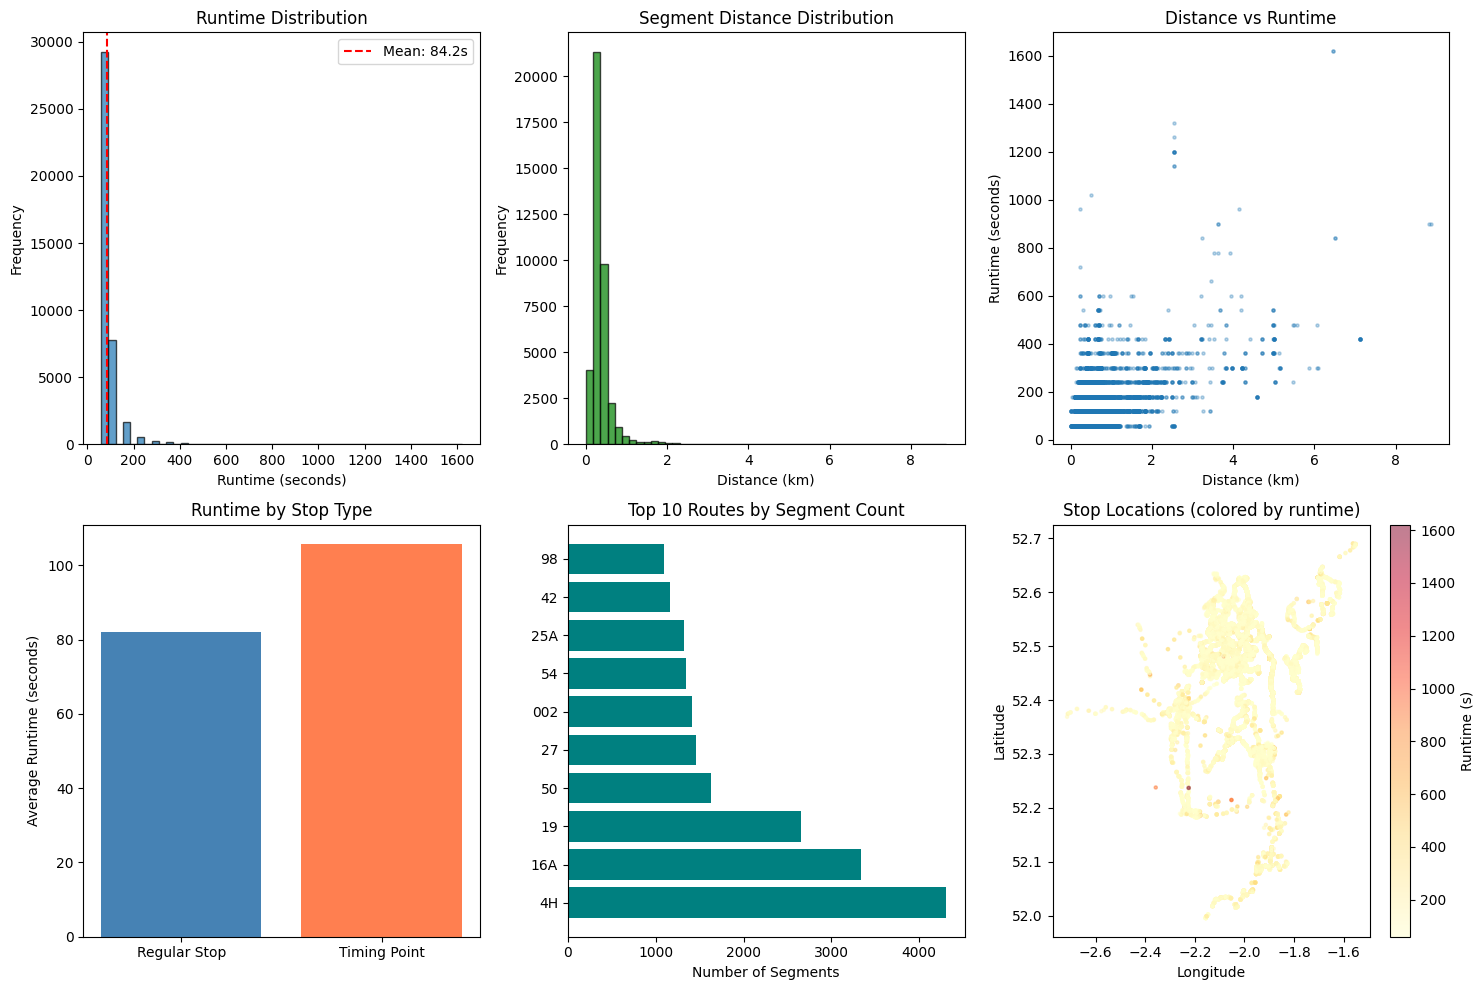

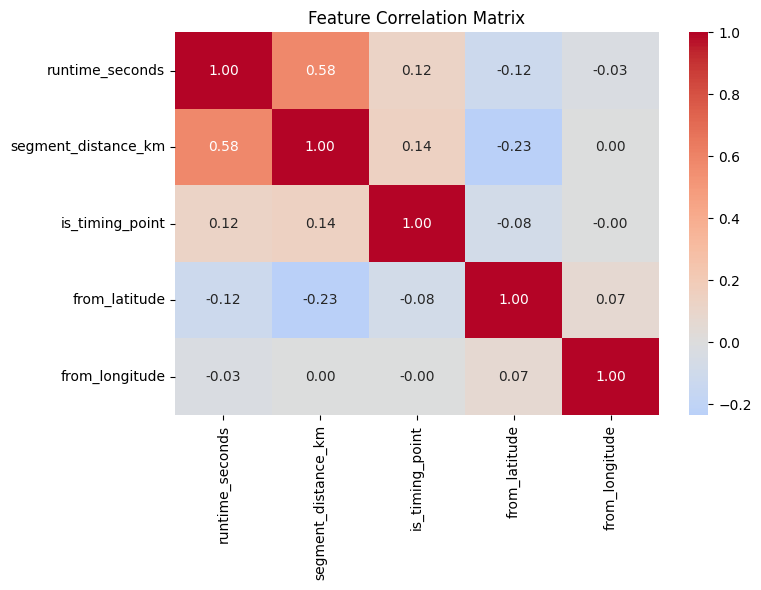

In [49]:
# ============================================================
# STEP 4: EDA VISUALIZATION
# ============================================================

print("=" * 60)
print("STEP 4: EXPLORATORY DATA ANALYSIS")
print("=" * 60)

# Convert to Pandas for visualization
df_viz = df_features.select(
    'runtime_seconds', 'segment_distance_km', 'is_timing_point',
    'avg_speed_kmh', 'line_name', 'from_latitude', 'from_longitude'
).toPandas()

# Statistics
print("\n--- Runtime Statistics ---")
print(f"Mean: {df_viz['runtime_seconds'].mean():.2f} seconds")
print(f"Median: {df_viz['runtime_seconds'].median():.2f} seconds")
print(f"Std Dev: {df_viz['runtime_seconds'].std():.2f} seconds")
print(f"Min: {df_viz['runtime_seconds'].min():.2f} seconds")
print(f"Max: {df_viz['runtime_seconds'].max():.2f} seconds")

print("\n--- Distance Statistics ---")
print(f"Mean: {df_viz['segment_distance_km'].mean():.4f} km")
print(f"Max: {df_viz['segment_distance_km'].max():.4f} km")

print("\n--- Correlation ---")
print(f"Distance vs Runtime: {df_viz['segment_distance_km'].corr(df_viz['runtime_seconds']):.4f}")

# Create visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot 1: Runtime Distribution
axes[0,0].hist(df_viz['runtime_seconds'], bins=50, edgecolor='black', alpha=0.7)
axes[0,0].axvline(df_viz['runtime_seconds'].mean(), color='red', linestyle='--', 
                   label=f"Mean: {df_viz['runtime_seconds'].mean():.1f}s")
axes[0,0].set_xlabel('Runtime (seconds)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Runtime Distribution')
axes[0,0].legend()

# Plot 2: Distance Distribution
axes[0,1].hist(df_viz['segment_distance_km'], bins=50, edgecolor='black', 
               alpha=0.7, color='green')
axes[0,1].set_xlabel('Distance (km)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Segment Distance Distribution')

# Plot 3: Distance vs Runtime (Key Relationship)
axes[0,2].scatter(df_viz['segment_distance_km'], df_viz['runtime_seconds'], 
                  alpha=0.3, s=5)
axes[0,2].set_xlabel('Distance (km)')
axes[0,2].set_ylabel('Runtime (seconds)')
axes[0,2].set_title('Distance vs Runtime')

# Plot 4: Runtime by Timing Point Status
timing_rt = df_viz.groupby('is_timing_point')['runtime_seconds'].mean()
axes[1,0].bar(['Regular Stop', 'Timing Point'], timing_rt.values, 
              color=['steelblue', 'coral'])
axes[1,0].set_ylabel('Average Runtime (seconds)')
axes[1,0].set_title('Runtime by Stop Type')

# Plot 5: Top 10 Routes
route_counts = df_viz['line_name'].value_counts().head(10)
axes[1,1].barh(route_counts.index, route_counts.values, color='teal')
axes[1,1].set_xlabel('Number of Segments')
axes[1,1].set_title('Top 10 Routes by Segment Count')

# Plot 6: Geographic Distribution
scatter = axes[1,2].scatter(df_viz['from_longitude'], df_viz['from_latitude'],
                            c=df_viz['runtime_seconds'], cmap='YlOrRd', 
                            alpha=0.5, s=5)
plt.colorbar(scatter, ax=axes[1,2], label='Runtime (s)')
axes[1,2].set_xlabel('Longitude')
axes[1,2].set_ylabel('Latitude')
axes[1,2].set_title('Stop Locations (colored by runtime)')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=150)
plt.show()

# Correlation Heatmap
numeric_cols = ['runtime_seconds', 'segment_distance_km', 'is_timing_point',
                'from_latitude', 'from_longitude']
corr_matrix = df_viz[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=150)
plt.show()

In [50]:
# ============================================================
# STEP 5: TRAIN TEST SPLIT
# ============================================================

print("=" * 60)
print("STEP 5: TRAIN TEST SPLIT")
print("=" * 60)

# Define model features
model_features = [
    'segment_distance_km', 'is_timing_point', 'to_is_timing_point',
    'is_pickup', 'lat_diff', 'lon_diff', 'heading_ns', 'heading_ew',
    'from_latitude', 'from_longitude', 'to_latitude', 'to_longitude'
]

# Prepare data
df_model = df_features.select(model_features + ['runtime_seconds', 'line_name'])
df_model = df_model.dropna()

# Encode line_name as numeric
line_indexer = StringIndexer(inputCol="line_name", outputCol="line_name_idx", 
                              handleInvalid="keep")
df_model = line_indexer.fit(df_model).transform(df_model)
model_features.append('line_name_idx')

# Assemble features into vector
assembler = VectorAssembler(inputCols=model_features, outputCol="features_raw",
                            handleInvalid="skip")
df_assembled = assembler.transform(df_model)

# Scale features
scaler = StandardScaler(inputCol="features_raw", outputCol="features",
                        withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Split: 80% train, 20% test
train_data, test_data = df_scaled.randomSplit([0.8, 0.2], seed=42)
train_data.cache()
test_data.cache()

print(f"Total records: {df_scaled.count()}")
print(f"Training set: {train_data.count()} ({train_data.count()/df_scaled.count()*100:.1f}%)")
print(f"Test set: {test_data.count()} ({test_data.count()/df_scaled.count()*100:.1f}%)")
print(f"Features: {len(model_features)}")

STEP 5: TRAIN TEST SPLIT
Total records: 39829
Training set: 31766 (79.8%)
Test set: 8063 (20.2%)
Features: 13


In [51]:
# ============================================================
# STEP 6: MODEL MAKING
# ============================================================

print("=" * 60)
print("STEP 6: MODEL TRAINING")
print("=" * 60)

# Model 1: Linear Regression (Baseline)
print("\nTraining Linear Regression (Baseline)...")
lr = LinearRegression(
    featuresCol="features",
    labelCol="runtime_seconds",
    maxIter=100,
    regParam=0.1
)
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
print("Linear Regression trained!")

# Model 2: Random Forest (Our Model)
print("\nTraining Random Forest (Our Model)...")
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="runtime_seconds",
    numTrees=100,
    maxDepth=10,
    seed=42
)
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
print("Random Forest trained!")

STEP 6: MODEL TRAINING

Training Linear Regression (Baseline)...
Linear Regression trained!

Training Random Forest (Our Model)...
Random Forest trained!


STEP 7: MODEL COMPARISON

--------------------------------------------------
Metric               Linear Reg      Random Forest  
--------------------------------------------------
RMSE (seconds)       44.6245         31.5969        
MAE (seconds)        24.7231         18.4369        
R² Score             0.3539          0.6761         
--------------------------------------------------

RMSE Improvement: 29.19%
>>> Random Forest OUTPERFORMS Linear Regression! <<<


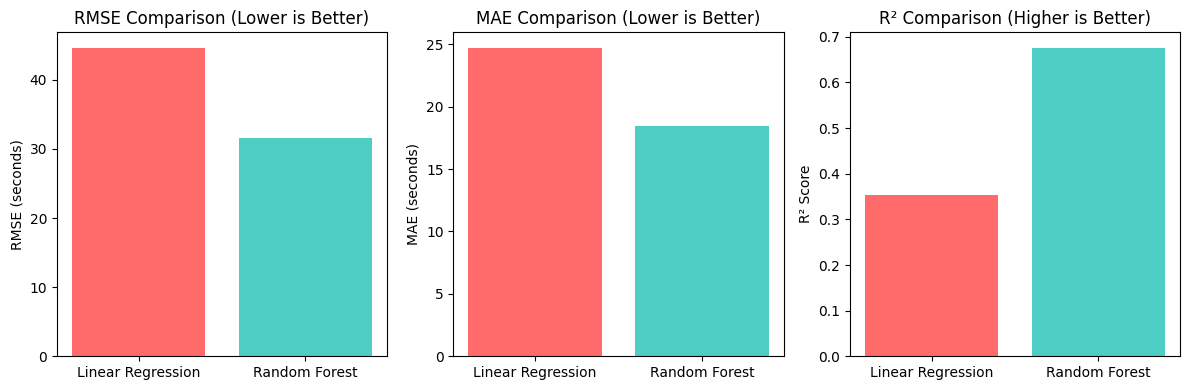

In [52]:
# ============================================================
# STEP 7: MODEL COMPARISON
# ============================================================

print("=" * 60)
print("STEP 7: MODEL COMPARISON")
print("=" * 60)

# Evaluators
evaluator_rmse = RegressionEvaluator(labelCol="runtime_seconds", 
                                      predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="runtime_seconds", 
                                     predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="runtime_seconds", 
                                    predictionCol="prediction", metricName="r2")

# Evaluate Linear Regression
lr_rmse = evaluator_rmse.evaluate(lr_predictions)
lr_mae = evaluator_mae.evaluate(lr_predictions)
lr_r2 = evaluator_r2.evaluate(lr_predictions)

# Evaluate Random Forest
rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_mae = evaluator_mae.evaluate(rf_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)

# Calculate improvements
rmse_improvement = ((lr_rmse - rf_rmse) / lr_rmse) * 100
r2_improvement = ((rf_r2 - lr_r2) / abs(lr_r2)) * 100 if lr_r2 != 0 else 0

# Print comparison
print("\n" + "-" * 50)
print(f"{'Metric':<20} {'Linear Reg':<15} {'Random Forest':<15}")
print("-" * 50)
print(f"{'RMSE (seconds)':<20} {lr_rmse:<15.4f} {rf_rmse:<15.4f}")
print(f"{'MAE (seconds)':<20} {lr_mae:<15.4f} {rf_mae:<15.4f}")
print(f"{'R² Score':<20} {lr_r2:<15.4f} {rf_r2:<15.4f}")
print("-" * 50)

print(f"\nRMSE Improvement: {rmse_improvement:.2f}%")
if rf_rmse < lr_rmse:
    print(">>> Random Forest OUTPERFORMS Linear Regression! <<<")
else:
    print(">>> Linear Regression performs better <<<")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
models = ['Linear Regression', 'Random Forest']
colors = ['#FF6B6B', '#4ECDC4']

axes[0].bar(models, [lr_rmse, rf_rmse], color=colors)
axes[0].set_ylabel('RMSE (seconds)')
axes[0].set_title('RMSE Comparison (Lower is Better)')

axes[1].bar(models, [lr_mae, rf_mae], color=colors)
axes[1].set_ylabel('MAE (seconds)')
axes[1].set_title('MAE Comparison (Lower is Better)')

axes[2].bar(models, [lr_r2, rf_r2], color=colors)
axes[2].set_ylabel('R² Score')
axes[2].set_title('R² Comparison (Higher is Better)')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150)
plt.show()

STEP 8: MODEL EVALUATION

--- Feature Importance ---

Top Features:
  1. segment_distance_km: 0.3265
  2. lon_diff: 0.1390
  3. lat_diff: 0.1084
  4. to_is_timing_point: 0.0910
  5. to_latitude: 0.0745
  6. from_latitude: 0.0691
  7. to_longitude: 0.0495
  8. from_longitude: 0.0470
  9. line_name_idx: 0.0419
  10. is_pickup: 0.0200

--- Residual Statistics ---
Mean Residual: 0.0273
Std Residual: 31.5989
Median Absolute Error: 9.6555

--- Error Distribution ---
  <10s: 51.3%
  10-30s: 28.6%
  30-60s: 16.7%
  60-120s: 2.6%
  >120s: 0.8%


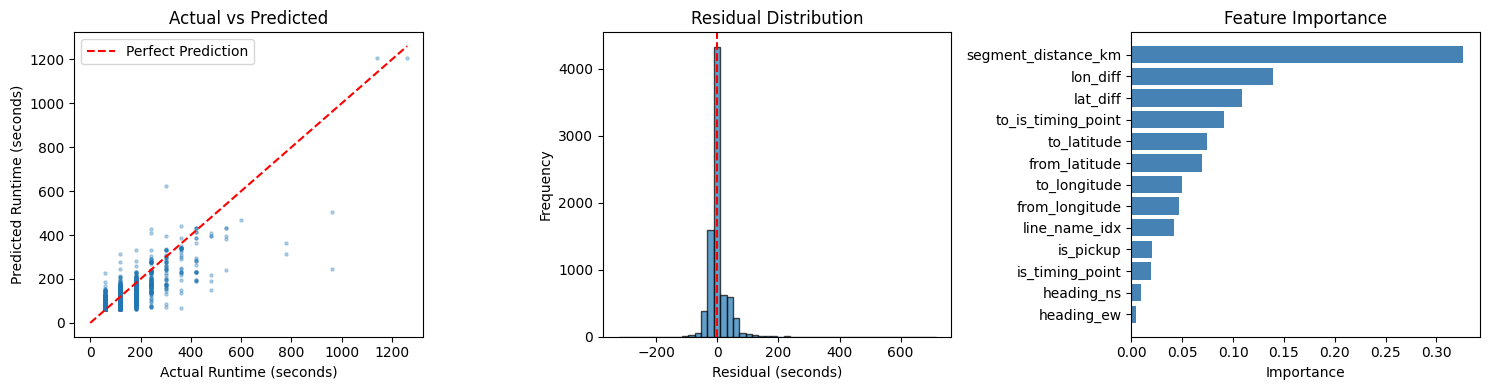

In [55]:
# ============================================================
# STEP 8: MODEL EVALUATION
# ============================================================

print("=" * 60)
print("STEP 8: MODEL EVALUATION")
print("=" * 60)

# Feature Importance (Random Forest)
print("\n--- Feature Importance ---")
importance = rf_model.featureImportances
importance_list = [(model_features[i], round(float(importance[i]), 4)) 
                   for i in range(len(model_features))]
importance_list.sort(key=lambda x: x[1], reverse=True)

print("\nTop Features:")
for i, (feat, imp) in enumerate(importance_list[:10], 1):
    print(f"  {i}. {feat}: {imp:.4f}")

# Residual Analysis
pred_pd = rf_predictions.select('runtime_seconds', 'prediction').toPandas()
pred_pd['residual'] = pred_pd['runtime_seconds'] - pred_pd['prediction']
pred_pd['abs_error'] = abs(pred_pd['residual'])

print("\n--- Residual Statistics ---")
print(f"Mean Residual: {pred_pd['residual'].mean():.4f}")
print(f"Std Residual: {pred_pd['residual'].std():.4f}")
print(f"Median Absolute Error: {pred_pd['abs_error'].median():.4f}")

# Error Distribution
pred_pd['error_bucket'] = pd.cut(pred_pd['abs_error'],
    bins=[0, 10, 30, 60, 120, float('inf')],
    labels=['<10s', '10-30s', '30-60s', '60-120s', '>120s'])
bucket_dist = pred_pd['error_bucket'].value_counts(normalize=True) * 100

print("\n--- Error Distribution ---")
for bucket, pct in bucket_dist.items():
    print(f"  {bucket}: {pct:.1f}%")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Actual vs Predicted
axes[0].scatter(pred_pd['runtime_seconds'], pred_pd['prediction'], alpha=0.3, s=5)
import builtins
max_val = builtins.max(pred_pd['runtime_seconds'].max(), pred_pd['prediction'].max())
axes[0].plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction')
axes[0].set_xlabel('Actual Runtime (seconds)')
axes[0].set_ylabel('Predicted Runtime (seconds)')
axes[0].set_title('Actual vs Predicted')
axes[0].legend()

# Residual Distribution
axes[1].hist(pred_pd['residual'], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--')
axes[1].set_xlabel('Residual (seconds)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

# Feature Importance
feat_names = [x[0] for x in importance_list]
feat_vals = [x[1] for x in importance_list]
axes[2].barh(feat_names, feat_vals, color='steelblue')
axes[2].set_xlabel('Importance')
axes[2].set_title('Feature Importance')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=150)
plt.show()


In [61]:
# ============================================================
# STEP 9: MODEL PREDICTION
# ============================================================

print("=" * 60)
print("STEP 9: MODEL PREDICTION")
print("=" * 60)

# Sample Predictions
print("\n--- Sample Predictions ---")
sample = rf_predictions.select(
    'line_name', 'segment_distance_km', 'runtime_seconds', 'prediction'
).limit(15)
sample.show(truncate=False)

# Prediction with error analysis
pred_sample = rf_predictions.select(
    'line_name', 'segment_distance_km', 'runtime_seconds', 'prediction'
).toPandas().head(20)

pred_sample['error'] = (pred_sample['runtime_seconds'] - pred_sample['prediction']).round(2)
pred_sample['error_pct'] = ((abs(pred_sample['error']) / pred_sample['runtime_seconds']) * 100).round(1)

print("\n--- Detailed Predictions ---")
print(pred_sample.to_string(index=False))

# Save model
MODEL_PATH = "travel_time_rf_model"
rf_model.write().overwrite().save(MODEL_PATH)
print(f"\nModel saved to: {MODEL_PATH}")

# Final Summary
print("\n" + "=" * 60)
print("PIPELINE COMPLETE!")
print("=" * 60)
print(f"""
Summary:
--------
- Dataset: {df_model.count():,} bus segments
- Features: {len(model_features)} engineered features
- Best Model: Random Forest

Metrics:
--------
- RMSE: {rf_rmse:.2f} seconds
- MAE: {rf_mae:.2f} seconds
- R²: {rf_r2:.4f}

Top 3 Predictive Features:
--------------------------
1. {importance_list[0][0]} ({importance_list[0][1]})
2. {importance_list[1][0]} ({importance_list[1][1]})
3. {importance_list[2][0]} ({importance_list[2][1]})

Files Generated:
----------------
- eda_visualizations.png
- correlation_heatmap.png
- model_comparison.png
- model_evaluation.png
- travel_time_rf_model/
""")

# Stop Spark
spark.stop()

STEP 9: MODEL PREDICTION

--- Sample Predictions ---
+---------+-------------------+---------------+------------------+
|line_name|segment_distance_km|runtime_seconds|prediction        |
+---------+-------------------+---------------+------------------+
|61       |0.11479382884386563|60             |63.6954936913898  |
|30       |0.14848926799756423|120            |62.29901402969994 |
|32       |0.1505681864917174 |60             |62.0082834757824  |
|150      |0.1705384962489348 |60             |62.859127628249574|
|76       |0.18047638831165097|60             |66.42084721902023 |
|19       |0.1830873787549345 |60             |62.51134397512772 |
|76C      |0.19429026660886128|60             |64.13581750226629 |
|52       |0.2007755028096195 |60             |63.08720449245956 |
|27       |0.2203022876904166 |60             |99.44821783017862 |
|32       |0.2220219809769647 |60             |62.221671790305784|
|50       |0.22549194503160974|60             |62.890919325997544|
|002     